# Peripheral Randomness Project — Analysis Notebook

This notebook analyzes the data collected by our experiment scripts

**Goal**
We compare randomness quality of bitstreams derived from:

- mouse only
- keyboard only
- combined mouse + keyboard

under two scenarios:

- **idle** (low activity)
- **active** (high activity)

We will:

1. Load event logs (CSV)
2. Perform sanity checks
3. Analyze inter-event intervals
4. Inspect bitstreams
5. Compute entropy metrics (Shannon entropy & min-entropy)
6. Prepare data for external validation (NIST SP 800-22, Dieharder)

NIST SP800-22 en Dieharder testen dingen als:

- Zijn er ongeveer evenveel 0’s als 1’s?

- Zijn de wisselingen 0↔1 random?

- Zit er periodiciteit in?


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import shutil
from pathlib import Path
import re

## Generate mock data bitstream for testing purpose

Call the function binary_number_gen() for the data

- path
- count= the bitcount in the stream

Expected formatting example:
`0b10101101101001 (256 bit long)`


In [2]:
def binary_number_gen(path, count):
    path = Path(path)
    with path.open("w", encoding="utf-8") as f:
        for _ in range(count):
            number = random.getrandbits(256)
            bit = format(number, f"0{256}b")
            f.write("0b" + bit + "\n")


# binary_number_gen("test_mouse_active_rns.txt", count=1000)

## Load bitstream data from path

- read mouse bitstream data


In [3]:
def load_string(path):
    lines = Path(path).read_text().split("0b")
    blocks = []
    for line in lines:
        if not line:
            continue

        if len(line) == 256:
            blocks.append(line)
    return blocks


keyboard_string = load_string("data/keyboard_rns.txt")
# print(keyboard_string[:2])
print(f"256bit number count Keyboard: {len(keyboard_string)}")

mouse_string = load_string("data/mouse_rns.txt")
# print(mouse_string[:2])
print(f"256bit number count Mouse: {len(mouse_string)}")

idle_string = load_string("data/idle_rns.txt")
# print(idle_string[:2])
print(f"256bit number count IDLE: {len(idle_string)}")

combination_string = load_string("data/combination_rns.txt")
# print(combination_string[:2])
print(f"256bit number count Combination: {len(combination_string)}")

256bit number count Keyboard: 905
256bit number count Mouse: 1351
256bit number count IDLE: 978
256bit number count Combination: 453


In [4]:
streams_blocks = {
    ("active", "keyboard"): keyboard_string,
    ("active", "mouse"): mouse_string,
    ("idle", "hw"): idle_string,
    ("active", "combo"): combination_string,
}

rows = []
for (scenario, source), blocks in streams_blocks.items():
    for b in blocks:
        rows.append(
            {
                "scenario": scenario,
                "source": source,
                "block": b,
            }
        )

df_blocks = pd.DataFrame(rows)
df_blocks.head()

,scenario,source,block
0,active,keyboard,0000000000010000000000000000000000000000000000...
1,active,keyboard,0000000000000000000000000000000000000000000000...
2,active,keyboard,0000000001000000000000000000000000000000000000...
3,active,keyboard,0000000000000000000000000000000000000000000000...
4,active,keyboard,0000000010000000000000000000000000000000000000...


### Simple bitcount in the bitstream


In [5]:
def blocks_to_bitstream(blocks_256):
    return "".join(blocks_256)


keyboard_stream = blocks_to_bitstream(keyboard_string)
mouse_stream = blocks_to_bitstream(mouse_string)
idle_stream = blocks_to_bitstream(idle_string)
combination_stream = blocks_to_bitstream(combination_string)

print(f"total bit number count Keyboard: {len(keyboard_stream)}")
print(f"total bit number count Mouse: {len(mouse_stream)}")
print(f"total bit number count IDLE: {len(idle_stream)}")
print(f"total bit number count Combination: {len(combination_stream)}")

total bit number count Keyboard: 231680
total bit number count Mouse: 345856
total bit number count IDLE: 250368
total bit number count Combination: 115968


In [ ]:
def bitstream_stats(stream):
    bits = np.fromiter(stream, dtype=np.uint8)
    n_bits = len(bits)
    frac_ones = bits.mean()

    runs = 1 + np.sum(bits[1:] != bits[:-1]) if n_bits > 0 else 0
    return n_bits, frac_ones, runs

def basic_stats_for_group(blocks):
    stream = "".join(blocks)
    n_bits, frac_ones, runs = bitstream_stats(stream)
    return pd.Series(
        {
            "n_bits": n_bits,
            "frac_ones": frac_ones,
            "runs": runs,
        }
    )


basic_stats = (
    df_blocks.groupby(["scenario", "source"])["block"]
    .apply(list)
    .apply(basic_stats_for_group)
    .reset_index()
)

basic_stats

,scenario,source,n_bits,frac_ones,runs
0,active,combo,115968.0,0.049807,10497.0
1,active,keyboard,231680.0,0.030262,12773.0
2,active,mouse,345856.0,0.018308,12133.0
3,idle,hw,250368.0,0.009734,4805.0


### Entropy per Bit

- IDLE vs Active
- HW vs mouse vs keyboard vs combo


In [8]:
def entropy_from_frac_ones(p):
    if p == 0 or p == 1:
        return 0.0
    return -(p * np.log2(p) + (1 - p) * np.log2(1 - p))


def min_entropy_from_frac_ones(p):
    return -np.log2(max(p, 1 - p))


def entropy_stats_for_group(blocks):
    stream = "".join(blocks)
    n_bits, frac_ones, _ = bitstream_stats(stream)
    H = entropy_from_frac_ones(frac_ones)
    Hmin = min_entropy_from_frac_ones(frac_ones)
    return pd.Series(
        {
            "n_bits": n_bits,
            "frac_ones": frac_ones,
            "H_per_bit": H,
            "Hmin_per_bit": Hmin,
        }
    )


entropy_stats = (
    df_blocks.groupby(["scenario", "source"])["block"]
    .apply(list)
    .apply(entropy_stats_for_group)
    .reset_index()
)

entropy_stats

,scenario,source,n_bits,frac_ones,H_per_bit,Hmin_per_bit
0,active,combo,115968.0,0.049807,0.285576,0.073707
1,active,keyboard,231680.0,0.030262,0.195702,0.044332
2,active,mouse,345856.0,0.018308,0.131833,0.026658
3,idle,hw,250368.0,0.009734,0.079022,0.014112


### Statistic per Block: fraction of ones + boxplot

For each 256-bit block, how many 1s occure?


In [9]:
def frac_ones_per_block(block):
    bits = np.fromiter(block, dtype=np.uint8)
    return bits.mean()


df_blocks["frac_ones_block"] = df_blocks["block"].apply(frac_ones_per_block)
df_blocks.head()

,scenario,source,block,frac_ones_block
0,active,keyboard,0000000000010000000000000000000000000000000000...,0.007812
1,active,keyboard,0000000000000000000000000000000000000000000000...,0.003906
2,active,keyboard,0000000001000000000000000000000000000000000000...,0.011719
3,active,keyboard,0000000000000000000000000000000000000000000000...,0.019531
4,active,keyboard,0000000010000000000000000000000000000000000000...,0.027344


<Figure size 800x400 with 0 Axes>

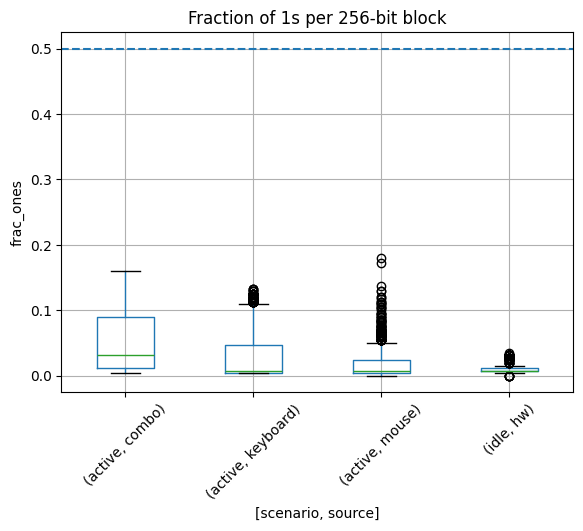

In [10]:
plt.figure(figsize=(8, 4))
df_blocks.boxplot(column="frac_ones_block", by=["scenario", "source"], rot=45)
plt.axhline(0.5, linestyle="--")
plt.title("Fraction of 1s per 256-bit block")
plt.suptitle("")
plt.ylabel("frac_ones")
plt.show()

### Collisions

"how often does the same 256-bit number occure?"


In [11]:
def collision_stats(blocks):
    n = len(blocks)
    unique = len(set(blocks))
    return pd.Series(
        {
            "n_blocks": n,
            "n_unique": unique,
            "collision_rate": 1 - unique / n,
        }
    )


collisions = (
    df_blocks.groupby(["scenario", "source"])["block"]
    .apply(list)
    .apply(collision_stats)
    .reset_index()
)

collisions

,scenario,source,n_blocks,n_unique,collision_rate
0,active,combo,453.0,452.0,0.002208
1,active,keyboard,905.0,747.0,0.174586
2,active,mouse,1351.0,918.0,0.320503
3,idle,hw,978.0,938.0,0.040900


Expectations:

- idle and HW could show more repetitional patterns --> higher collision_rate
- active mouse/keyboard/combination should ideally show less repetitional patterns


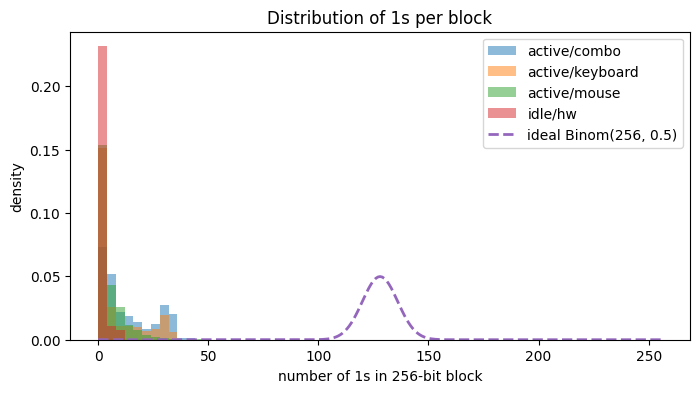

In [12]:
# count 1's per block
df_blocks["ones_count"] = df_blocks["block"].apply(
    lambda b: np.fromiter(b, dtype=np.uint8).sum()
)

plt.figure(figsize=(8, 4))
for (scenario, source), g in df_blocks.groupby(["scenario", "source"]):
    plt.hist(
        g["ones_count"],
        bins=range(0, 257, 4),
        alpha=0.5,
        label=f"{scenario}/{source}",
        density=True,
    )

# Theoretical reference (Binom(256, 0.5))
from scipy.stats import binom

k = np.arange(0, 257)
pmf = binom.pmf(k, 256, 0.5)
plt.plot(k, pmf, linestyle="--", linewidth=2, label="ideal Binom(256, 0.5)")

plt.xlabel("number of 1s in 256-bit block")
plt.ylabel("density")
plt.title("Distribution of 1s per block")
plt.legend()
plt.show()

### Hamming distance on blocks

The distance shows how many bits differ between block `i` and block `i+1`, etc.


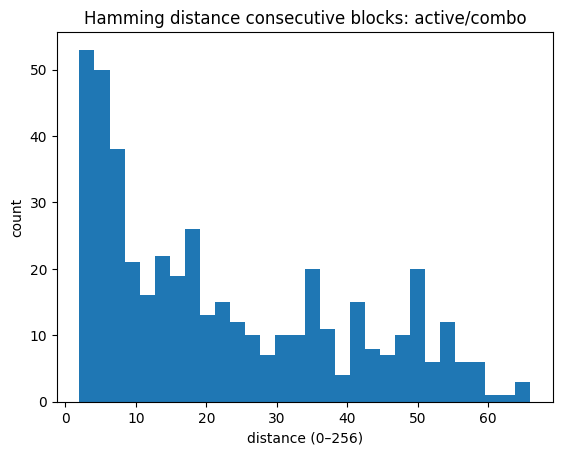

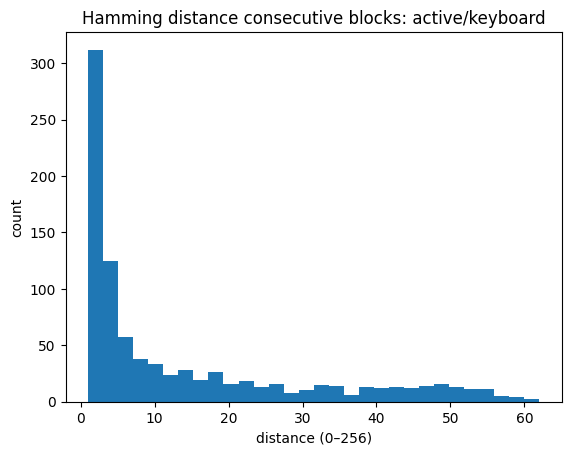

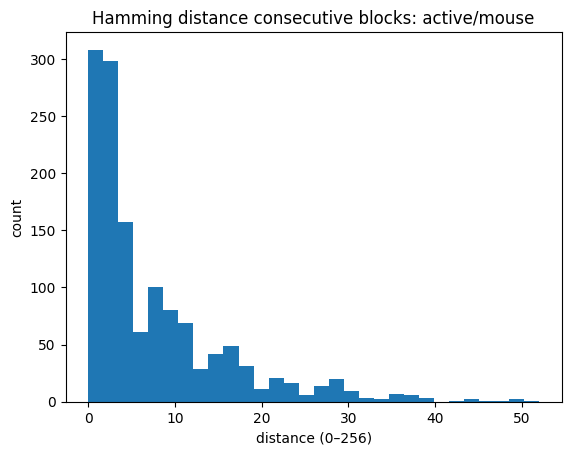

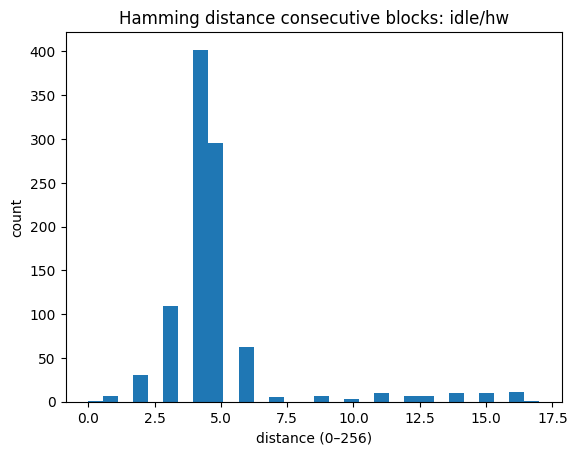

In [13]:
def hamming(a, b):
    return sum(c1 != c2 for c1, c2 in zip(a, b))


def hamming_distances(blocks, max_pairs=2000):
    ds = []
    for i in range(min(len(blocks) - 1, max_pairs)):
        ds.append(hamming(blocks[i], blocks[i + 1]))
    return np.array(ds)


for (scenario, source), g in df_blocks.groupby(["scenario", "source"]):
    blocks = g["block"].tolist()
    ds = hamming_distances(blocks)
    if len(ds) == 0:
        continue
    plt.figure()
    plt.hist(ds, bins=30)
    plt.title(f"Hamming distance consecutive blocks: {scenario}/{source}")
    plt.xlabel("distance (0–256)")
    plt.ylabel("count")
    plt.show()

### Bit-position bias heatmap

For each scenario discover if there excist a bias in bit-positioning. It could occure that for the Most significant Bit (MSB) or Least Significant Bit (LSB) systematically more often being 1 or 0.


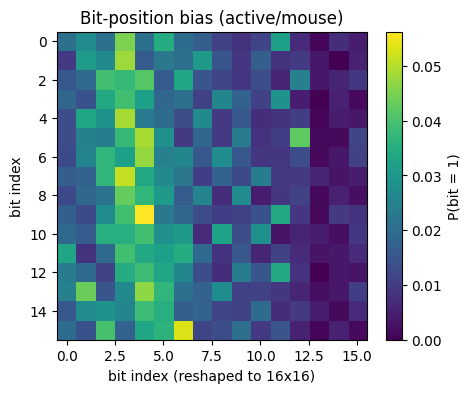

In [14]:
def bit_bias(blocks):
    arr = np.array([[int(c) for c in b] for b in blocks])
    return arr.mean(axis=0)  # P(bit = 1) per positie


# example: active/mouse
blocks_mouse = df_blocks.query("scenario == 'active' and source == 'mouse'")[
    "block"
].tolist()
bias_mouse = bit_bias(blocks_mouse)

plt.figure(figsize=(5, 4))
plt.imshow(bias_mouse.reshape(16, 16), aspect="auto")
plt.colorbar(label="P(bit = 1)")
plt.title("Bit-position bias (active/mouse)")
plt.xlabel("bit index (reshaped to 16x16)")
plt.ylabel("bit index")
plt.show()

In [15]:
def save_stream(stream, out_path):
    Path(out_path).write_text(stream, encoding="utf-8")


PROJECT_ROOT = Path(".").resolve()
RESULTS_DIR = PROJECT_ROOT / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)


save_stream(keyboard_stream, RESULTS_DIR / "keyboard_rns.bits.txt")
save_stream(mouse_stream, RESULTS_DIR / "mouse_rns.bits.txt")
save_stream(idle_stream, RESULTS_DIR / "idle_rns.bits.txt")
save_stream(combination_stream, RESULTS_DIR / "combination_rns.bits.txt")

# Prep data for NIST Testing

We are using chunk sizes of 100k for NIST and dieharder testing

NIST work with minimum chunks of 100k bits


In [16]:
def chunk_stream(stream, chunk_size=100_000):
    return [
        stream[i : i + chunk_size]
        for i in range(0, len(stream), chunk_size)
        if len(stream[i : i + chunk_size]) == chunk_size
    ]


def make_nist_chunks(stream, label, chunk_size=100_000):
    chunks = chunk_stream(stream, chunk_size)
    paths = []
    for i, c in enumerate(chunks, 1):
        path = NIST_INPUTS_DIR / f"{label}_chunk{i}.bits.txt"
        path.write_text(c, encoding="utf-8")
        paths.append(path)
    print(
        f"{label}: {len(paths)} chunks of {chunk_size} bits written to {NIST_INPUTS_DIR}"
    )
    return paths


def make_single_nist_input(stream, label, n_bits=100_000):
    if len(stream) < n_bits:
        raise ValueError(
            f"Stream '{label}' is too short: {len(stream)} bits < {n_bits}"
        )

    bitblock = stream[:n_bits]

    out_path = NIST_INPUTS_DIR / f"{label}_{n_bits}_bits.txt"
    out_path.write_text(bitblock, encoding="utf-8")

    print(f"[NIST] Created {out_path}")
    return out_path


STS_DIR = PROJECT_ROOT / "sts-2.1.2"
NIST_DATA_DIR = STS_DIR / "data"  # nist expect here ./assess input_stream.txt
NIST_INPUTS_DIR = STS_DIR / "nist_inputs"  # here store all chunks
NIST_INPUTS_DIR.mkdir(parents=True, exist_ok=True)


streams = {
    "mouse_active": mouse_stream,
    "keyboard_active": keyboard_stream,
    "idle_hw": idle_stream,
    "combo_active": combination_stream,
}

nist_inputs = {}
for label, stream in streams.items():
    nist_inputs[label] = make_single_nist_input(stream, label)

[NIST] Created /Users/jelteoldenhof/Projects/master/semester_3/sss/assignment2/sourcecode/S-SS_project/sts-2.1.2/nist_inputs/mouse_active_100000_bits.txt
[NIST] Created /Users/jelteoldenhof/Projects/master/semester_3/sss/assignment2/sourcecode/S-SS_project/sts-2.1.2/nist_inputs/keyboard_active_100000_bits.txt
[NIST] Created /Users/jelteoldenhof/Projects/master/semester_3/sss/assignment2/sourcecode/S-SS_project/sts-2.1.2/nist_inputs/idle_hw_100000_bits.txt
[NIST] Created /Users/jelteoldenhof/Projects/master/semester_3/sss/assignment2/sourcecode/S-SS_project/sts-2.1.2/nist_inputs/combo_active_100000_bits.txt


## Copy chunk to NIST data folder


In [23]:
def copy_to_nist(bitfile):
    dest = NIST_DATA_DIR / "input_stream.txt"
    shutil.copy(bitfile, dest)
    print(f"[NIST] Copied {bitfile} -> {dest}")
    return dest


copy_to_nist(
    nist_inputs["combo_active"]
)  # set one input file for NIST ready, each time
# NOW RUN NIST TEST --------

[NIST] Copied /Users/jelteoldenhof/Projects/master/semester_3/sss/assignment2/sourcecode/S-SS_project/sts-2.1.2/nist_inputs/combo_active_100000_bits.txt -> /Users/jelteoldenhof/Projects/master/semester_3/sss/assignment2/sourcecode/S-SS_project/sts-2.1.2/data/input_stream.txt


PosixPath('/Users/jelteoldenhof/Projects/master/semester_3/sss/assignment2/sourcecode/S-SS_project/sts-2.1.2/data/input_stream.txt')

## Run NIST from TERMINAL here

Terminal input commands:

`sts-2.1.2 % ./assess 100000`

G E N E R A T O R S E L E C T I O N

- [0] Input File
- [1] Linear Congruential
- [2] Quadratic Congruential I
- [3] Quadratic Congruential II
- [4] Cubic Congruential
- [5] XOR
- [6] Modular Exponentiation
- [7] Blum-Blum-Shub
- [8] Micali-Schnorr
- [9] G Using SHA-1 

Enter Choice: `0` 

User Prescribed

Input File: `data/input_stream.txt`

S T A T I S T I C A L T E S T S

- [01] Frequency
- [02] Block Frequency
- [03] Cumulative Sums
- [04] Runs
- [05] Longest Run of Ones
- [06] Rank
- [07] Discrete Fourier Transform
- [08] Nonperiodic Template Matchings
- [09] Overlapping Template Matchings
- [10] Universal Statistical
- [11] Approximate Entropy
- [12] Random Excursions
- [13] Random Excursions Variant
- [14] Serial
- [15] Linear Complexity

INSTRUCTIONS
Enter 0 if you DO NOT want to apply all of the statistical tests to each sequence and 1 if you DO.
Enter Choice: `1`

P a r a m e t e r A d j u s t m e n t s

- [1] Block Frequency Test - block length(M): 128
- [2] NonOverlapping Template Test - block length(m): 9
- [3] Overlapping Template Test - block length(m): 9
- [4] Approximate Entropy Test - block length(m): 10
- [5] Serial Test - block length(m): 16
- [6] Linear Complexity Test - block length(M): 500

Select Test (0 to continue): `0`

How many bitstreams? `1`

Input File Format:

- [0] ASCII - A sequence of ASCII 0's and 1's
- [1] Binary - Each byte in data file contains 8 bits of data

Select input mode: `0`

Statistical Testing In Progress.........

Statistical Testing Complete!!!!!!!!!!!!


In [18]:
print("CWD:", Path().resolve())
print("Experiments exists?", Path("sts-2.1.2/experiments").exists())
print("Subdirs:", list(Path("sts-2.1.2/experiments").glob("*")))

CWD: /Users/jelteoldenhof/Projects/master/semester_3/sss/assignment2/sourcecode/S-SS_project
Experiments exists? True
Subdirs: [PosixPath('sts-2.1.2/experiments/XOR'), PosixPath('sts-2.1.2/experiments/MS'), PosixPath('sts-2.1.2/experiments/LCG'), PosixPath('sts-2.1.2/experiments/QCG1'), PosixPath('sts-2.1.2/experiments/MODEXP'), PosixPath('sts-2.1.2/experiments/AlgorithmTesting'), PosixPath('sts-2.1.2/experiments/G-SHA1'), PosixPath('sts-2.1.2/experiments/create-dir-script'), PosixPath('sts-2.1.2/experiments/QCG2'), PosixPath('sts-2.1.2/experiments/BBS'), PosixPath('sts-2.1.2/experiments/CCG')]


In [19]:
root = Path("sts-2.1.2/experiments")

stats_files = list(root.rglob("stats.txt"))
print("Aantal stats.txt gevonden:", len(stats_files))
for p in stats_files:
    print(p)

Aantal stats.txt gevonden: 15
sts-2.1.2/experiments/AlgorithmTesting/NonOverlappingTemplate/stats.txt
sts-2.1.2/experiments/AlgorithmTesting/OverlappingTemplate/stats.txt
sts-2.1.2/experiments/AlgorithmTesting/Universal/stats.txt
sts-2.1.2/experiments/AlgorithmTesting/Frequency/stats.txt
sts-2.1.2/experiments/AlgorithmTesting/ApproximateEntropy/stats.txt
sts-2.1.2/experiments/AlgorithmTesting/LinearComplexity/stats.txt
sts-2.1.2/experiments/AlgorithmTesting/RandomExcursionsVariant/stats.txt
sts-2.1.2/experiments/AlgorithmTesting/CumulativeSums/stats.txt
sts-2.1.2/experiments/AlgorithmTesting/BlockFrequency/stats.txt
sts-2.1.2/experiments/AlgorithmTesting/FFT/stats.txt
sts-2.1.2/experiments/AlgorithmTesting/RandomExcursions/stats.txt
sts-2.1.2/experiments/AlgorithmTesting/Rank/stats.txt
sts-2.1.2/experiments/AlgorithmTesting/Runs/stats.txt
sts-2.1.2/experiments/AlgorithmTesting/Serial/stats.txt
sts-2.1.2/experiments/AlgorithmTesting/LongestRun/stats.txt


In [20]:
def parse_nist_pvalues(experiments_root="sts-2.1.2/experiments/AlgorithmTesting"):
    root = Path(experiments_root)
    rows = []

    for stats_file in root.rglob("stats.txt"):
        text = stats_file.read_text(errors="ignore")
        # zoek naar "p_value = ..."
        match = re.search(r"p_value\s*=\s*([0-9\.Ee\-]+)", text)
        if not match:
            continue

        try:
            pval = float(match.group(1))
        except ValueError:
            continue

        # testnaam is de mapnaam net boven stats.txt
        test_name = stats_file.parent.name

        rows.append(
            {
                "test_name": test_name,
                "p_value": pval,
            }
        )

    if not rows:
        return pd.DataFrame(columns=["test_name", "p_value", "stats_path"])

    df = pd.DataFrame(rows).drop_duplicates(subset=["test_name"])
    return df.sort_values("test_name").reset_index(drop=True)


df_nist = parse_nist_pvalues()
df_nist

,test_name,p_value
0,ApproximateEntropy,0.0
1,BlockFrequency,0.0
2,CumulativeSums,0.0
3,FFT,0.0
4,Frequency,0.0
5,LongestRun,0.0
6,Rank,0.0


In [21]:
ALPHA = 0.01

df_nist["result"] = df_nist["p_value"].apply(lambda p: "FAIL" if p < ALPHA else "PASS")
df_nist

,test_name,p_value,result
0,ApproximateEntropy,0.0,FAIL
1,BlockFrequency,0.0,FAIL
2,CumulativeSums,0.0,FAIL
3,FFT,0.0,FAIL
4,Frequency,0.0,FAIL
5,LongestRun,0.0,FAIL
6,Rank,0.0,FAIL
